## Analysis of a ribosome profiling data using a transcriptome assembly as a reference

This analysis includes a highly phased ribosome profiling data for _Salmonella enterica_ serovar Typhimurium (PRJEB51486) and PacBio long-read and Illumina short-read data for transcriptome assembly (PRJEB6002)

### On a local machine to use Docker

#### 1. Download PacBio long-read RNA-seq data (strain D23005)

```
mkdir -p ~/Documents/manuscript/riboss ~/Documents/manuscript/riboss/styphimurium

cd ~/Documents/manuscript/riboss/styphimurium

wget "https://www.ebi.ac.uk/ena/portal/api/filereport?accession=PRJEB6002&result=read_run&fields=study_accession,sample_accession,secondary_sample_accession,experiment_accession,run_accession,tax_id,scientific_name,instrument_model,library_layout,library_strategy,library_source,fastq_ftp,submitted_ftp,sra_ftp,sample_alias,sample_title,bam_ftp&format=tsv&download=true&limit=0" -O filereport_read_run_PRJEB6002_tsv.txt

awk 'BEGIN{FS="\t"} /m140726_040902|m140801_073558|m140814_095222/ {print $13}' \
    filereport_read_run_PRJEB6002_tsv.txt \
    | tr ';' '\n' \
    | awk '{print "wget -nc ftp://" $1}' | sh
```

#### 2. Download and run a Docker image for SMRT-analysis 2.3.0

```
sudo docker pull jyang88/smrtanalysis2.3.0:latest

sudo docker run -it -v /home/chunlim/Documents:/data jyang88/smrtanalysis2.3.0:latest bash

/opt/smrtanalysis/current/smrtcmds/bin/smrtshell

cd data/manuscript/riboss/styphimurium
```

#### 3. Create files of file names for SMRT-analysis

```
ls m140726_040902* > m140726_040902.fofn
ls m140801_073558* > m140801_073558.fofn
ls m140814_095222* > m140814_095222.fofn
```

#### 4. Construct CCS reads

```
for i in \*.fofn; do \
    ConsensusTools.sh CircularConsensus \
    --minFullPasses 0 --minPredictedAccuracy 75 \
    --parameters /opt/smrtanalysis/install/smrtanalysis_2.3.0.140936/analysis/etc/algorithm_parameters/2014-09/ \
    --numThreads 32 --fofn $i \
    -o output
done

cp output/*.fastq

gzip *.fastq
```

#### 5. Exit docker image and scp the the CCS fastq files to a server to continue the analysis

### On a server

#### 6. Download ribosome profiling and RNA-seq data (strain LT2)
Follow README to create conda environment and clone the RIBOSS repository if you haven't already done so.
```
cd riboss
```

```
mkdir -p doc/styphimurium/riboseq

cd doc/styphimurium/riboseq

wget "https://www.ebi.ac.uk/ena/portal/api/filereport?accession=PRJEB51486&result=read_run&fields=study_accession,sample_accession,secondary_sample_accession,experiment_accession,run_accession,tax_id,scientific_name,instrument_model,library_layout,library_strategy,library_source,fastq_ftp,submitted_ftp,sra_ftp,sample_alias,sample_title,bam_ftp&format=tsv&download=true&limit=0" -O filereport_read_run_PRJEB51486_tsv.txt

awk 'BEGIN{FS="\t"} NR>1 {print "wget -nc ftp://" $12}' filereport_read_run_PRJEB51486_tsv.txt | sh
```

#### 7. Download Illumina short-read RNA-seq alignment files (strain D23005)

```
mkdir doc/styphimurium/rnaseq/illumina

cd doc/styphimurium/rnaseq/illumina

awk 'BEGIN{FS="\t"} /14256_2#2|14256_2#8|14256_2#14|14256_2#5|14256_2#11|14256_2#17|13851_1#14|13851_1#13|13851_1#15/ {print $13}' \
    filereport_read_run_PRJEB6002_tsv.txt \
    | tr ';' '\n' \
    | awk '{print "wget -nc ftp://" $1}' | sh

#### 8. Install samtools (for handling CRAM quickly, [not](https://github.com/samtools/htslib/issues/605) a recommended installation method)

```
git clone https://github.com/samtools/samtools.git
cd samtools
SAMTOOLSDIR=$PWD
# git checkout eb0992ff8a99b895364a7a861b418a1beb77d540

wget https://github.com/samtools/htslib/releases/download/1.21/htslib-1.21.tar.bz2
tar jxvf htslib-1.21.tar.bz2
cd htslib-1.21
./configure --enable-libcurl --prefix=$PWD
make
cd ..

./configure --enable-plugins --enable-libcurl --with-htslib=$PWD/htslib-1.21
make all all-htslib
```

#### 9. Merge CRAM files

```
$SAMTOOLSDIR/samtools merge \
    14256_2\#2.cram 14256_2\#8.cram 14256_2\#14.cram \
    14256_2\#5.cram 14256_2\#11.cram 14256_2\#17.cram \
    13851_1\#14.cram 13851_1\#13.cram 13851_1\#15.cram \
    -o D23005.cram

samtools sort D23005.cram -O BAM -o ../D23005.sorted.bam

rm D23005.cram
```

#### 10. Download the LT2 reference genome for transcriptome_assembly

```
mkdir -p ref

cd ref

wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/006/945/GCF_000006945.1_ASM694v1/GCF_000006945.1_ASM694v1_genomic.fna.gz

zcat GCF_000006945.1_ASM694v1_genomic.fna.gz \
    | sed 's/NC_003197.1/gi|16763390|ref|NC_003197.1|/' \
    > NC_003197.1.fasta

wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/006/945/GCF_000006945.1_ASM694v1/GCF_000006945.1_ASM694v1_genomic.gff.gz

zcat GCF_000006945.1_ASM694v1_genomic.gff.gz \
    | gff3ToGenePred stdin stdout \
    | genePredToBed stdin stdout \
    | awk '/NC_003197.1/ && sub("NC_003197.1","gi|16763390|ref|NC_003197.1|")' \
    > NC_003197.1.bed
```

#### 11. Download and convert GFF3 to BED and GTF for operon_finder

```
wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/006/945/GCF_000006945.2_ASM694v2/GCF_000006945.2_ASM694v2_genomic.gff.gz

zcat GCF_000006945.2_ASM694v2_genomic.gff.gz \
    | gff3ToGenePred stdin stdout \
    | genePredToBed stdin stdout \
    > NC_003197.2.bed

zcat GCF_000006945.2_ASM694v2_genomic.gff.gz \
    | gff3ToGenePred stdin stdout \
    | genePredToGtf file stdin stdout \
    > NC_003197.2.gtf
```

#### 12. Infer library type for short-read alignment

```
conda activate riboss
pip install rseqc
```

In [1]:
# https://www.biostars.org/p/295344/#295402
# So if 1++,1--,2+-,2-+" get more signal (Value) then its fr-secondstrand
# and if 1+-,1-+,2++,2-- get more signal (Value) then its fr-firststrand

! infer_experiment.py -i doc/styphimurium/rnaseq/D23005.sorted.bam -r ref/NC_003197.1.bed

Reading reference gene model ref/NC_003197.1.bed ... Done
Loading SAM/BAM file ...  Total 200000 usable reads were sampled


This is PairEnd Data
Fraction of reads failed to determine: 0.0004
Fraction of reads explained by "1++,1--,2+-,2-+": 0.1697
Fraction of reads explained by "1+-,1-+,2++,2--": 0.8299


#### 13. Map PacBio long reads to genome and merge alignment files (strain D23005)

```
mkdir -p doc \
    doc/styphimurium \
    doc/styphimurium/rnaseq \
    doc/styphimurium/rnaseq/pacbio

cd doc/styphimurium/rnaseq/pacbio

for i in _.gz; do \
    minimap2 -ax splice:hq -uf --sam-hit-only --MD \
    ref/NC_003197.1.fasta \
    $i > ${i%%.*}.sam
done

samtools merge \
    m140726_040902_00127_c100661342550000001823130211271434_s1_p0.sam \
    m140801_073558_00127_c100661152550000001823130211271487_s1_p0.sam \
    m140814_095222_00127_c100669272550000001823130511271461_s1_p0.sam \
    -O BAM -o D23005-sc-1962750.bam

samtools sort D23005-sc-1962750.bam -O BAM -o ../D23005-sc-1962750.sorted.bam

rm D23005-sc-1962750.bam
```

#### 14. Assemble transcriptome by combining PacBio long-read and Illumina short-read RNA-seq data (strain D23005)

In [2]:
import os
from glob import glob
from riboss.wrapper import transcriptome_assembly

superkingdom = 'Bacteria'
genome = 'ref/NC_003197.1.fasta'
short_reads = 'doc/styphimurium/rnaseq/D23005.sorted.bam' 
long_reads = 'doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.bam'
strandness = 'rf'

tx_assembly, gtf = transcriptome_assembly(superkingdom, genome, long_reads, short_reads, strandness)

INFO:root:saved StringTie GTF as doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.gtf
INFO:root:converted transcriptome assembly to doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.bed
INFO:root:extracted sequences to doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.transcripts.fa


#### 15. Remap transcriptome assembly to newly assembled genome

```
wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/006/945/GCF_000006945.2_ASM694v2/GCF_000006945.2_ASM694v2_genomic.fna.gz

# required for PyRanges
gunzip ref/GCF_000006945.2_ASM694v2_genomic.fna.gz

minimap2 -ax splice:hq -uf --sam-hit-only --MD \
    ref/GCF_000006945.2_ASM694v2_genomic.fna \
    doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.transcripts.fa \
    | samtools view -b - \
    > doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.transcripts.bam

bedtools bamtobed -i \
    doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.transcripts.bam \
    > doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.transcripts.bed
```

In [3]:
import pandas as pd
import pyranges as pr

genome='ref/GCF_000006945.2_ASM694v2_genomic.fna'
remap = pd.read_csv('doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.transcripts.bed', 
                    sep='\t', header=None)
# drop fragmented transcripts
remap['STRG'] = remap[3].str.split('::').str[0]
remap.drop_duplicates('STRG', keep=False, inplace=True)

remap['tid'] = '>' + remap['STRG'] + '::' + remap[0] + ':' + remap[1].astype(str) + '-' + remap[2].astype(str) + '(' + remap[5] + ')'
remap = remap[[0,1,2,'tid',5]]
remap.columns = ['Chromosome','Start','End','tid','Strand']
remap = pr.PyRanges(remap)
remap.dna = pr.get_sequence(remap, genome)
remap.df[['tid','dna']].to_csv('doc/styphimurium/rnaseq/D23005-sc-1962750.fa',
                               sep='\n', index=None, header=None)

#### 16. Build STAR index for the newly assembled transcriptome

In [1]:
import os
from riboss.wrapper import build_star_index

tx_assembly = 'doc/styphimurium/rnaseq/D23005-sc-1962750.fa'
index = tx_assembly.split(os.extsep)[0]

build_star_index(tx_assembly, index)

	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode genomeGenerate --runThreadN 4 --genomeDir doc/styphimurium/rnaseq/D23005-sc-1962750 --genomeFastaFiles doc/styphimurium/rnaseq/D23005-sc-1962750.fa --genomeSAindexNbases 7 --genomeChrBinNbits 11
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Oct 29 17:58:53 ..... started STAR run
Oct 29 17:58:53 ... starting to generate Genome files
Oct 29 17:58:53 ... starting to sort Suffix Array. This may take a long time...
Oct 29 17:58:53 ... sorting Suffix Array chunks and saving them to disk...
Oct 29 17:58:53 ... loading chunks from disk, packing SA...
Oct 29 17:58:54 ... finished generating suffix array
Oct 29 17:58:54 ... generating Suffix Array index
Oct 29 17:58:54 ... completed Suffix Array index
Oct 29 17:58:54 ... writing Genome to disk ...
Oct 29 17:58:54 ... writing Suffix Array to disk ...


INFO:root:saved index to doc/styphimurium/rnaseq/D23005-sc-1962750


Oct 29 17:58:54 ... writing SAindex to disk
Oct 29 17:58:54 ..... finished successfully


#### 17. Map ribosome footprints to transcriptome

In [2]:
from glob import glob
from riboss.wrapper import align_short_reads

for i in glob('doc/styphimurium/riboseq/*[0-9].fastq.gz'):
    prefix = i.split(os.extsep)[0]    
    align_short_reads(i, prefix, index)

	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode alignReads --readFilesIn doc/styphimurium/riboseq/ERR9130946.fastq.gz --outFileNamePrefix doc/styphimurium/riboseq/ERR9130946 --genomeDir doc/styphimurium/rnaseq/D23005-sc-1962750 --runThreadN 4 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --outSAMmode NoQS --outSAMattributes NH NM
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Oct 29 17:58:57 ..... started STAR run
Oct 29 17:58:57 ..... loading genome
Oct 29 17:58:57 ..... started mapping


INFO:root:saved alignment to doc/styphimurium/riboseq/ERR9130946Aligned.out.bam


Oct 29 18:03:58 ..... finished mapping
Oct 29 18:03:58 ..... finished successfully
	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode alignReads --readFilesIn doc/styphimurium/riboseq/ERR9130943.fastq.gz --outFileNamePrefix doc/styphimurium/riboseq/ERR9130943 --genomeDir doc/styphimurium/rnaseq/D23005-sc-1962750 --runThreadN 4 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --outSAMmode NoQS --outSAMattributes NH NM
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Oct 29 18:03:58 ..... started STAR run
Oct 29 18:03:58 ..... loading genome
Oct 29 18:03:58 ..... started mapping


INFO:root:saved alignment to doc/styphimurium/riboseq/ERR9130943Aligned.out.bam


Oct 29 18:07:05 ..... finished mapping
Oct 29 18:07:05 ..... finished successfully
	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode alignReads --readFilesIn doc/styphimurium/riboseq/ERR9130945.fastq.gz --outFileNamePrefix doc/styphimurium/riboseq/ERR9130945 --genomeDir doc/styphimurium/rnaseq/D23005-sc-1962750 --runThreadN 4 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --outSAMmode NoQS --outSAMattributes NH NM
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Oct 29 18:07:05 ..... started STAR run
Oct 29 18:07:05 ..... loading genome
Oct 29 18:07:05 ..... started mapping


INFO:root:saved alignment to doc/styphimurium/riboseq/ERR9130945Aligned.out.bam


Oct 29 18:08:49 ..... finished mapping
Oct 29 18:08:49 ..... finished successfully
	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode alignReads --readFilesIn doc/styphimurium/riboseq/ERR9130944.fastq.gz --outFileNamePrefix doc/styphimurium/riboseq/ERR9130944 --genomeDir doc/styphimurium/rnaseq/D23005-sc-1962750 --runThreadN 4 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --outSAMmode NoQS --outSAMattributes NH NM
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Oct 29 18:08:49 ..... started STAR run
Oct 29 18:08:49 ..... loading genome
Oct 29 18:08:49 ..... started mapping


INFO:root:saved alignment to doc/styphimurium/riboseq/ERR9130944Aligned.out.bam


Oct 29 18:10:59 ..... finished mapping
Oct 29 18:10:59 ..... finished successfully
	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode alignReads --readFilesIn doc/styphimurium/riboseq/ERR9130942.fastq.gz --outFileNamePrefix doc/styphimurium/riboseq/ERR9130942 --genomeDir doc/styphimurium/rnaseq/D23005-sc-1962750 --runThreadN 4 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --outSAMmode NoQS --outSAMattributes NH NM
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Oct 29 18:10:59 ..... started STAR run
Oct 29 18:10:59 ..... loading genome
Oct 29 18:10:59 ..... started mapping


INFO:root:saved alignment to doc/styphimurium/riboseq/ERR9130942Aligned.out.bam


Oct 29 18:12:34 ..... finished mapping
Oct 29 18:12:34 ..... finished successfully


#### 18. Predict operons from transcriptome assembly

finding all ORFs       : 100%|███████████████████████████████████████████████| 256/256 [00:01<00:00, 208it/s]
INFO:root:plotted the distribution of operons as results/operon_finder/D23005-sc-1962750.operon_dist.pdf andresults/operon_finder/D23005-sc-1962750.operon_scatter.pdf
INFO:root:saved operons and ORFs as results/operon_finder/D23005-sc-1962750.operon_finder.pkl.gz
INFO:root:saved operons and ORFs as results/operon_finder/D23005-sc-1962750.genomic_range.pkl.gz
INFO:root:saved CDS range as results/operon_finder/D23005-sc-1962750.cds_range.txt


ORF_type
oORF     30991
sORF     27498
mORF       899
opORF      577
Name: count, dtype: int64

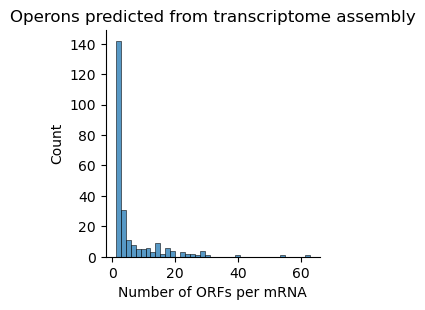

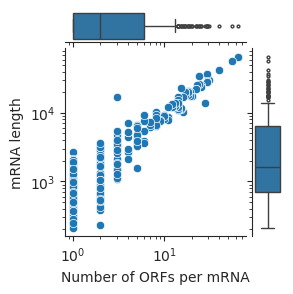

In [3]:
from riboss.orfs import operon_finder
import pyranges as pr
import pandas as pd

bed = 'ref/NC_003197.2.bed'
outdir = 'results/operon_finder'
tx_assembly = 'doc/styphimurium/rnaseq/D23005-sc-1962750.fa'
delim = '::'

cds_range, orf, df = operon_finder(tx_assembly, bed, outdir, delim)
df.value_counts('ORF_type')

#### 19. Analyse ribosome footprints

analyse_footprints allows the aligned footprint positions to be adjusted to the P-site, either from the 5' or 3' end through the offset_method. For this data, the 5' offset method produced more consistent triplet periodicity for the footprint sizes 25 nt and 28 nt (see metagene plots).

downsampling BAM       : 4944612it [00:06, 733057.62it/s]
comparing periodicity  : 100%|████████████████████████████████████████████| 11.0/11.0 [00:02<00:00, 3.98it/s]
INFO:root:saved selected footprint sizes with an offset as results/analyse_footprints/ERR9130942Aligned.out.offset.txt
INFO:root:converted mapped frames into heatmaps as results/analyse_footprints/ERR9130942Aligned.out.frames.pdf
INFO:root:saved metagene plots as results/analyse_footprints/ERR9130942Aligned.out.start_codon.pdf and results/analyse_footprints/ERR9130942Aligned.out.stop_codon.pdf
downsampling BAM       : 12595789it [00:16, 755695.14it/s]
comparing periodicity  : 100%|████████████████████████████████████████████| 11.0/11.0 [00:06<00:00, 1.60it/s]
INFO:root:saved selected footprint sizes with an offset as results/analyse_footprints/ERR9130943Aligned.out.offset.txt
INFO:root:converted mapped frames into heatmaps as results/analyse_footprints/ERR9130943Aligned.out.frames.pdf
INFO:root:saved metagene plots as re

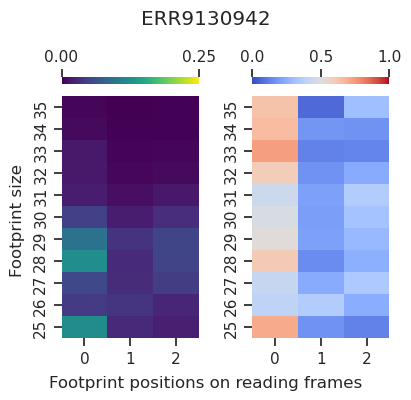

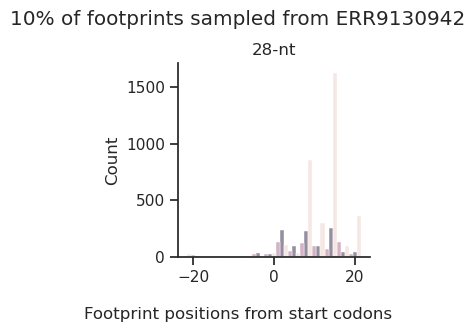

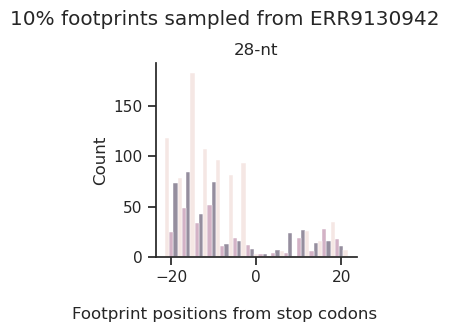

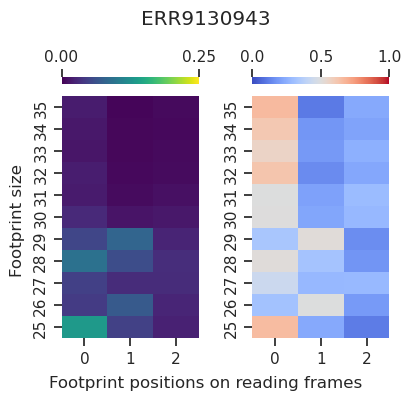

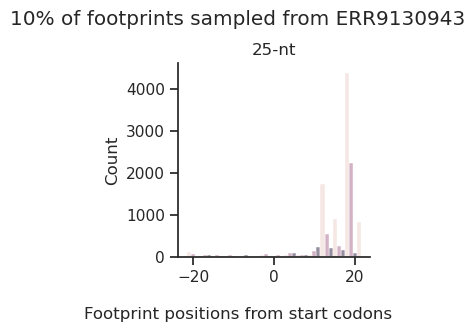

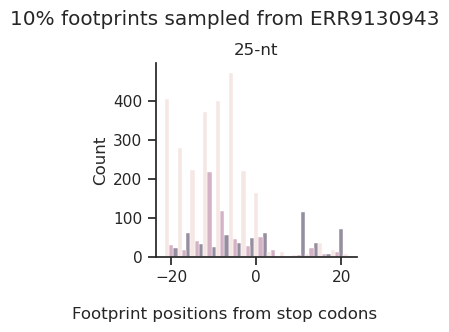

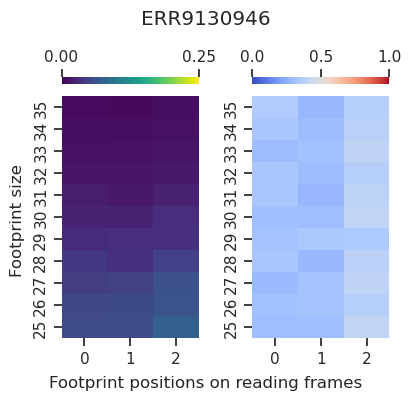

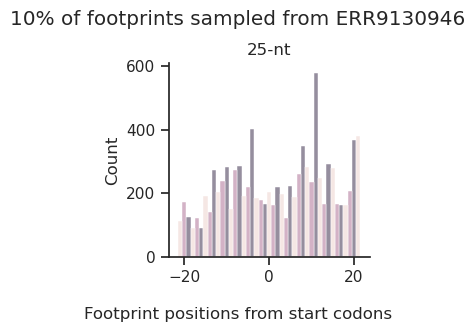

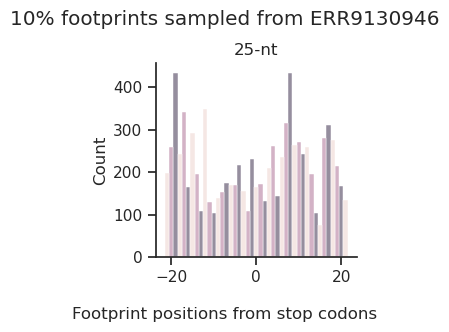

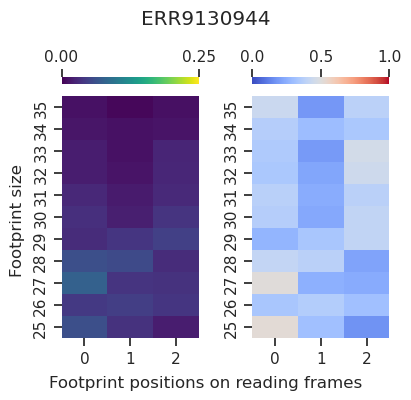

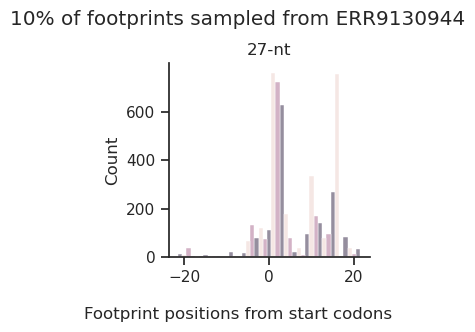

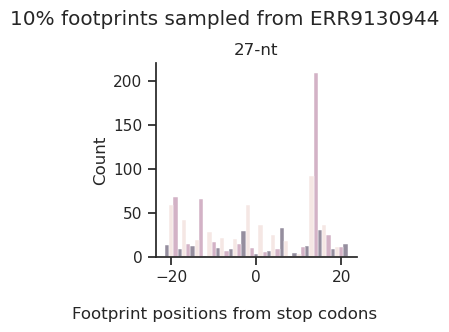

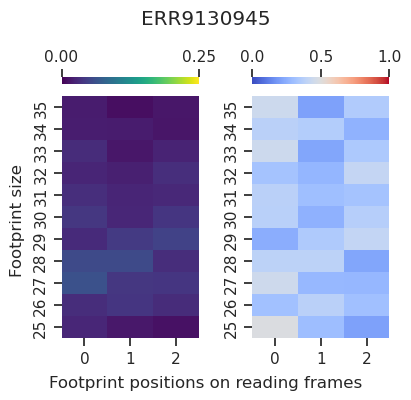

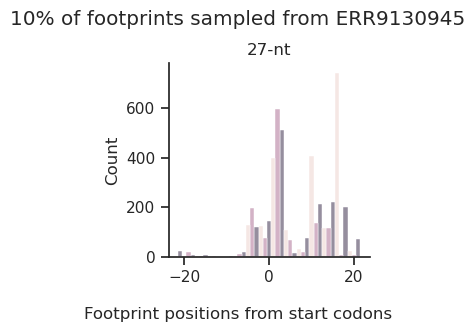

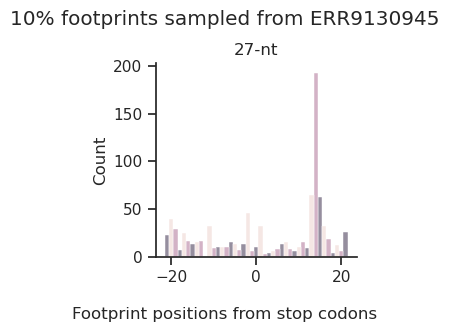

In [4]:
from riboss.footprints import analyse_footprints
from glob import glob

downsampling = 0.1
offset_method = '3p'
adj = 13
outdir = 'results/analyse_footprints'

footprint_stats = []
for i in glob('doc/styphimurium/riboseq/*Aligned.out.bam'):
    stats = analyse_footprints(offset_method, adj, i, downsampling, cds_range, 'best', outdir)
    footprint_stats.append(stats)

downsampling BAM       : 4944612it [00:07, 666377.46it/s]
comparing periodicity  : 100%|████████████████████████████████████████████| 11.0/11.0 [00:02<00:00, 3.76it/s]
INFO:root:saved selected footprint sizes with an offset as results/analyse_footprints/ERR9130942Aligned.out.offset.txt
INFO:root:converted mapped frames into heatmaps as results/analyse_footprints/ERR9130942Aligned.out.frames.pdf
INFO:root:saved metagene plots as results/analyse_footprints/ERR9130942Aligned.out.start_codon.pdf and results/analyse_footprints/ERR9130942Aligned.out.stop_codon.pdf
downsampling BAM       : 12595789it [00:18, 695284.26it/s]
comparing periodicity  : 100%|████████████████████████████████████████████| 11.0/11.0 [00:07<00:00, 1.52it/s]
INFO:root:saved selected footprint sizes with an offset as results/analyse_footprints/ERR9130943Aligned.out.offset.txt
INFO:root:converted mapped frames into heatmaps as results/analyse_footprints/ERR9130943Aligned.out.frames.pdf
INFO:root:saved metagene plots as re

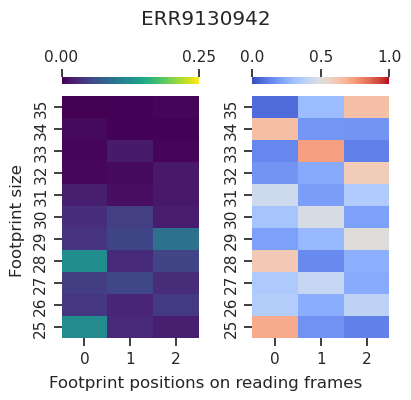

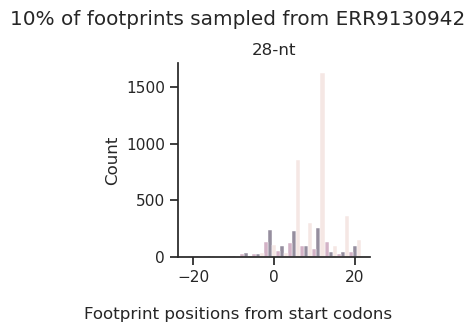

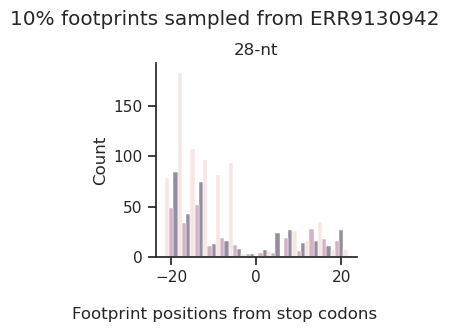

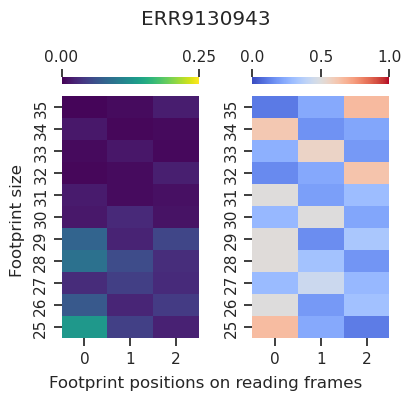

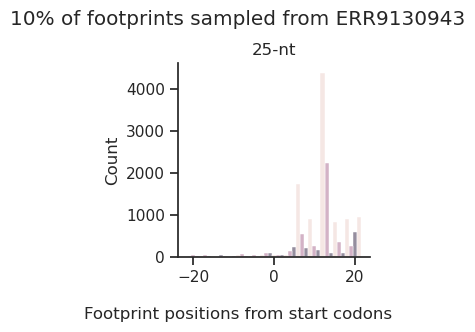

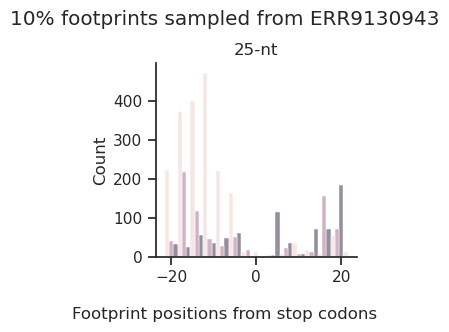

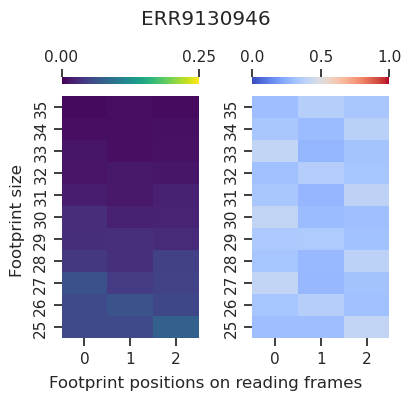

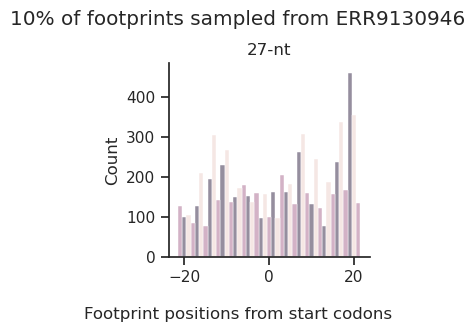

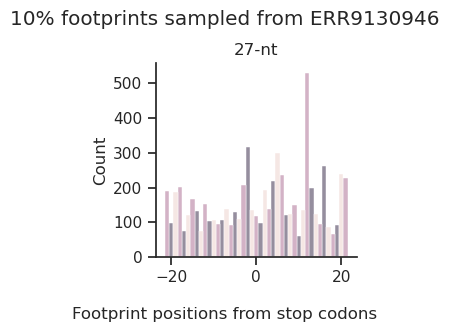

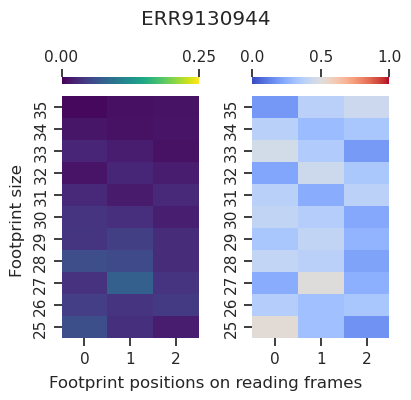

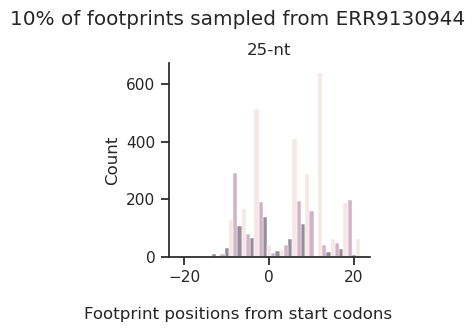

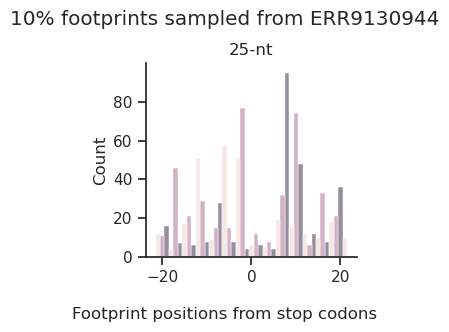

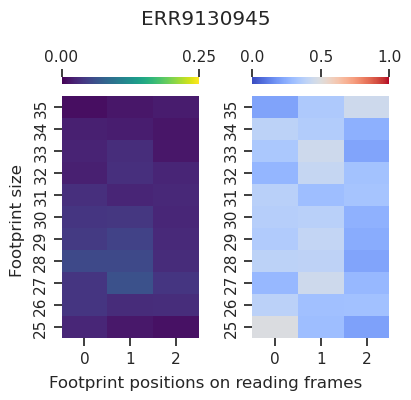

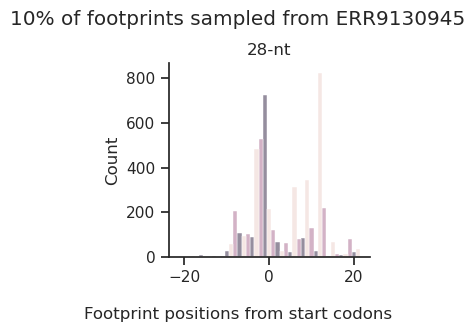

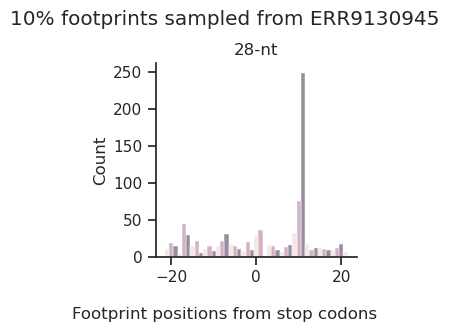

In [5]:
from riboss.footprints import analyse_footprints
from glob import glob

offset_method = '5p'
adj = 12
downsampling = 0.1
outdir = 'results/analyse_footprints'

footprint_stats = []
for i in glob('doc/styphimurium/riboseq/*Aligned.out.bam'):
    stats = analyse_footprints(offset_method, adj, i, downsampling, cds_range, 'best', outdir)
    footprint_stats.append(stats)

In [6]:
import pandas as pd

filereport = pd.read_csv('doc/styphimurium/riboseq/filereport_read_run_PRJEB51486_tsv.txt', sep='\t')
filereport[['run_accession','sample_title']]

,run_accession,sample_title
0,ERR9130944,RiboSeq S7 1000U
1,ERR9130945,RiboSeq S7 750U
2,ERR9130942,RiboSeq RNase1 1000U
3,ERR9130943,RiboSeq RNase1 500U
4,ERR9130946,RNA-Seq


#### 20. Merge ribosome profiling data and footprint offset files

In [7]:
! samtools merge \
    doc/styphimurium/riboseq/ERR9130942Aligned.out.bam \
    doc/styphimurium/riboseq/ERR9130943Aligned.out.bam \
    -f -o doc/styphimurium/riboseq/ERR9130942_3.bam

! cat results/analyse_footprints/ERR9130943Aligned.out.offset.txt \
    results/analyse_footprints/ERR9130942Aligned.out.offset.txt > \
    results/analyse_footprints/offset.txt

#### 21. Build salmon index using transcriptome assembly and run salmon quant

In [9]:
from riboss.wrapper import quantify_transcripts

index = 'doc/styphimurium/rnaseq/D23005-sc-1962750'
tx_assembly = 'doc/styphimurium/rnaseq/D23005-sc-1962750.fa'
rnaseq = 'doc/styphimurium/riboseq/ERR9130946.fastq.gz'

quantify_transcripts(rnaseq, tx_assembly, index)

Version Server Response: Not Found
index ["doc/styphimurium/rnaseq/D23005-sc-1962750_puff"] did not previously exist  . . . creating it
[2024-10-29 18:31:53.010] [jLog] [warning] The salmon index is being built without any decoy sequences.  It is recommended that decoy sequence (either computed auxiliary decoy sequence or the genome of the organism) be provided during indexing. Further details can be found at https://salmon.readthedocs.io/en/latest/salmon.html#preparing-transcriptome-indices-mapping-based-mode.
[2024-10-29 18:31:53.010] [jLog] [info] building index
out : doc/styphimurium/rnaseq/D23005-sc-1962750_puff
[2024-10-29 18:31:53.013] [puff::index::jointLog] [info] Running fixFasta

[Step 1 of 4] : counting k-mers

[2024-10-29 18:31:53.057] [puff::index::jointLog] [info] Replaced 0 non-ATCG nucleotides
[2024-10-29 18:31:53.057] [puff::index::jointLog] [info] Clipped poly-A tails from 0 transcripts
wrote 256 cleaned references
[2024-10-29 18:31:53.103] [puff::index::jointLog] [i

Threads = 2
Vertex length = 31
Hash functions = 5
Filter size = 33554432
Capacity = 2
Files: 
doc/styphimurium/rnaseq/D23005-sc-1962750_puff/ref_k31_fixed.fa
--------------------------------------------------------------------------------
Round 0, 0:33554432
Pass	Filling	Filtering
1	0	0	
2	0	0
True junctions count = 119
False junctions count = 3074
Hash table size = 3193
Candidate marks count = 3354
--------------------------------------------------------------------------------
Reallocating bifurcations time: 0
True marks count: 770
Edges construction time: 0
--------------------------------------------------------------------------------
Distinct junctions = 119



TwoPaCo::buildGraphMain:: allocated with scalable_malloc; freeing.
TwoPaCo::buildGraphMain:: Calling scalable_allocation_command(TBBMALLOC_CLEAN_ALL_BUFFERS, 0);
allowedIn: 42
Max Junction ID: 658
seen.size():5273 kmerInfo.size():659
approximateContigTotalLength: 1287910
counters for complex kmers:
(prec>1 & succ>1)=14 | (succ>1 & isStart)=1 | (prec>1 & isEnd)=0 | (isStart & isEnd)=0
contig count: 435 element count: 1409613 complex nodes: 15
# of ones in rank vector: 434
[2024-10-29 18:31:53.546] [puff::index::jointLog] [info] Starting the Pufferfish indexing by reading the GFA binary file.
[2024-10-29 18:31:53.546] [puff::index::jointLog] [info] Setting the index/BinaryGfa directory doc/styphimurium/rnaseq/D23005-sc-1962750_puff
size = 1409613
-----------------------------------------
| Loading contigs | Time = 1.298 ms
-----------------------------------------
size = 1409613
-----------------------------------------
| Loading contig boundaries | Time = 1.0855 ms
---------------------

for info, total work write each  : 2.331    total work inram from level 3 : 4.322  total work raw : 25.000 
Bitarray         7323648  bits (100.00 %)   (array + ranks )
final hash             0  bits (0.00 %) (nb in final hash 0)




INFO:root:saved index to doc/styphimurium/rnaseq/D23005-sc-1962750_puff/
INFO:root:saved read counts to doc/styphimurium/riboseq/ERR9130946_salmon_quant/


#### 22. Run riboprof (ribomap)

In [10]:
from riboss.wrapper import riboprofiler

offset = 'results/analyse_footprints/offset.txt'
ribobam = 'doc/styphimurium/riboseq/ERR9130942_3.bam'
mrnabam = 'doc/styphimurium/riboseq/ERR9130946Aligned.out.bam'
tx_assembly = 'doc/styphimurium/rnaseq/D23005-sc-1962750.fa'
sf = 'doc/styphimurium/riboseq/ERR9130946_salmon_quant/quant.sf'
out = 'results/riboprofiler/ERR9130942_3'
cds_range_file = 'results/operon_finder/D23005-sc-1962750.cds_range.txt'

riboprof_base = riboprofiler(offset, ribobam, mrnabam, 
                             tx_assembly, cds_range_file, 
                             sf, out)

getting transcript info...
total number of transcripts in transcriptome: 256
assigning ribo-seq reads...
constructing profile class...
number of transcripts in profile class: 253
loading reads from bam...
getting readlen mapping to P site offset...
getting alignment records...
total number of reads: 10486879
getting read type and p-sites...
total output footprint: 10486879
total: 10486879	multi_mapped: 101467 (0.97 %)
assigning reads to frame 0 loci...
reads used: 1563729 reads assigned: 1563729
assigning reads to frame 1 and 2 loci...
reads used: 2348772 reads assigned: 2348772
assigning reads to UTR loci...
reads used: 4078426 reads assigned: 4078426
assigning RNA-seq reads...
number of transcripts in profile class: 253
loading reads from bam...
getting alignment records...
total number of reads: 10778748
getting read type and p-sites...
total output footprint: 10778748
total: 10778748	multi_mapped: 185177 (1.72 %)
assigning reads...
reads used: 10778748 reads assigned: 10778748
writ

INFO:root:saved main output as results/riboprofiler/ERR9130942_3.base


#### 23. Find new ORFs using the main RIBOSS function

parsing ribomap output : 100%|█████████████████████████████████████████████| 249/249 [00:00<00:00, 2.41kit/s]
INFO:root:saved ribosome profiles as results/riboss/ERR9130942_3.riboprof.plus.bg and results/riboss/ERR9130942_3.riboprof.minus.bg
counting footprints    : 100%|█████████████████████████████████████████| 59.8k/59.8k [00:00<00:00, 85.4kit/s]
comparing periodicity  :  10%|████▏                                       | 937/9.71k [02:25<14:17, 10.2it/s]INFO:root:[[0.0, 1.0]]
INFO:root:[[0.0, 1.0]]
INFO:root:[[0.0, 1.0]]
comparing periodicity  :  28%|███████████▊                              | 2.75k/9.71k [07:31<10:48, 10.7it/s]INFO:root:[[0.0, 1.0]]
INFO:root:[[0.0, 1.0]]
INFO:root:[[0.0, 1.0]]
INFO:root:[[0.0, 1.0]]
comparing periodicity  :  52%|█████████████████████▉                    | 5.08k/9.71k [13:29<08:30, 9.08it/s]INFO:root:[[0.0, 1.0]]
INFO:root:[[0.0, 1.0]]
INFO:root:[[0.0, 1.0]]
INFO:root:[[0.0, 1.0]]
INFO:root:[[0.0, 1.0]]
INFO:root:[[0.0, 1.0]]
INFO:root:[[0.0, 1.0]]

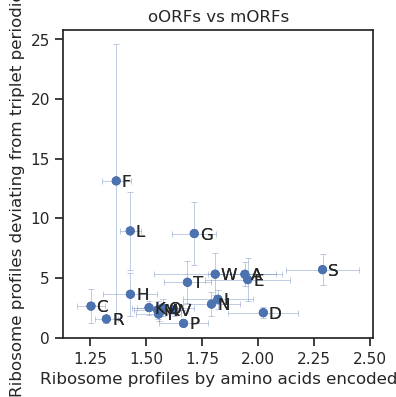

INFO:root:saved scatterplot for anomaly ribosome profiles as results/riboss/ERR9130942_3.riboss.riboprof_aa.pdf
INFO:root:saved metagene plots as results/riboss/ERR9130942_3.riboss.oporfs_blastp_hits.start_codon.pdf
INFO:root:saved metagene plots as results/riboss/ERR9130942_3.riboss.oporfs_no_blastp_hits.start_codon.pdf
INFO:root:saved metagene plots as results/riboss/ERR9130942_3.riboss.oorfs_blastp_hits.start_codon.pdf
INFO:root:saved metagene plots as results/riboss/ERR9130942_3.riboss.oorfs_no_blastp_hits.start_codon.pdf
INFO:root:saved metagene plots as results/riboss/ERR9130942_3.riboss.sorfs_blastp_hits.start_codon.pdf
INFO:root:saved metagene plots as results/riboss/ERR9130942_3.riboss.sorfs_no_blastp_hits.start_codon.pdf
INFO:root:saved BLASTP results for RIBOSS hits as results/riboss/ERR9130942_3.riboss.tophits.pkl.gz, results/riboss/ERR9130942_3.riboss.sig.blastp.csv, results/riboss/ERR9130942_3.riboss.sig.blastp.json, and results/riboss/ERR9130942_3.riboss.sig.blastp.pkl.g

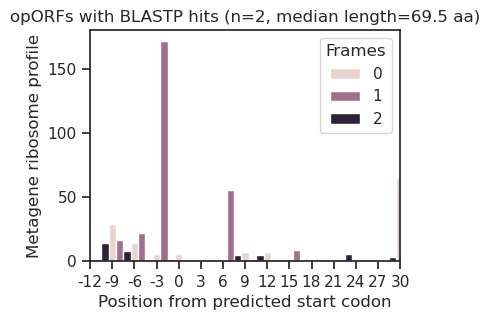

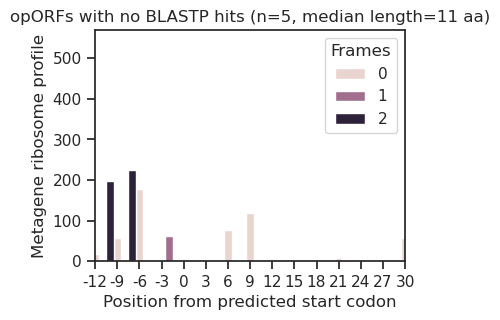

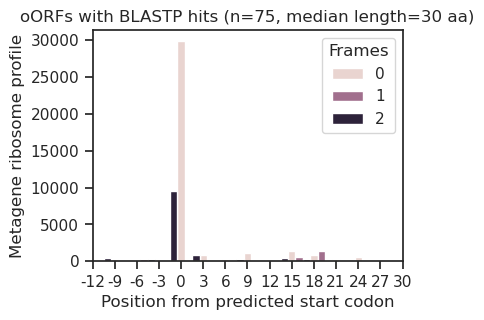

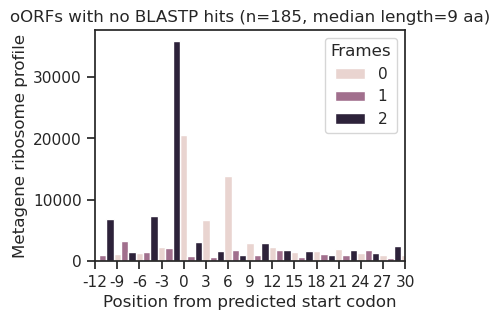

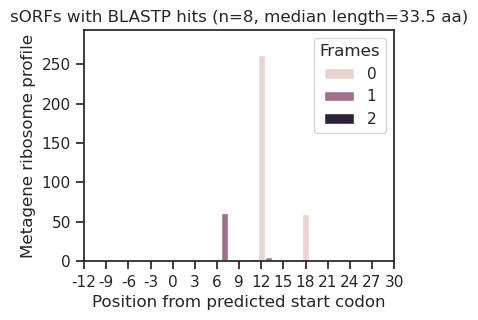

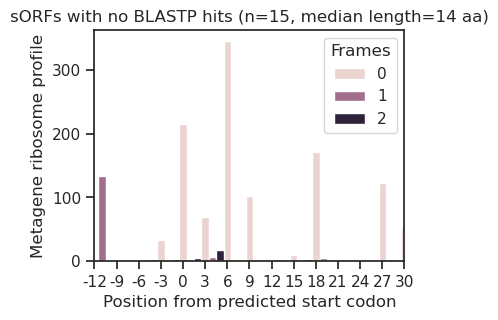

In [11]:
from riboss.riboss import riboss
import pandas as pd

riboprof_base = 'results/riboprofiler/ERR9130942_3.base'
tx_assembly = 'doc/styphimurium/rnaseq/D23005-sc-1962750.fa'
fasta = 'ref/GCF_000006945.2_ASM694v2_genomic.fna'
fai = 'ref/GCF_000006945.2_ASM694v2_genomic.fna.fai'
bed = 'ref/NC_003197.2.bed'
superkingdom='Bacteria'
outdir = 'results/riboss'
email='chunshen.lim@otago.ac.nz'
api_key='55890b8dfafe4d49e57c5f1d031aec4c2509'

ipg, tophits, blast, sig, boss_df = riboss(superkingdom, df, orf, riboprof_base, tx_assembly, fasta, fai, bed,
                                           tie=False, 
                                           run_blastp=True, run_efetch=True, 
                                           email=email, api_key=api_key, 
                                           delim='::',
                                           outdir=outdir)

#### 24. Visit the [_S_. Typhimurium LT2 genome](https://genome.ucsc.edu/h/GCF_000006945.2) at the UCSC Genome Browser
Click "Manage custom tracks" and submit the tracks below using "Paste URLs or Data".

1. BigGenePred annotation track for predicted sORFs:
```
track type=bigGenePred name="sORFs" description="RIBOSS top hits" baseColorDefault=genomicCodons bigDataUrl=https://github.com/lcscs12345/riboss/raw/refs/heads/master/results/riboss/ERR9130942_3.riboss.sORF.tophits.bb
```

2. BedGraph for ribosome profiles:
```
https://raw.githubusercontent.com/lcscs12345/riboss/refs/heads/master/results/riboss/ERR9130942_3.riboprof.bg
```

3. BED annotation track for transcriptome assembly:
```
https://github.com/lcscs12345/riboss/raw/refs/heads/master/doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.transcripts.bed
```